# Generate Features

In [84]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from utils.import_utils import *
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
with initialize(config_path='../configuration', version_base='1.1'):
    config = compose(config_name='main.yaml')
survey_list = SurveyManager(config)
dfs_paradata, dfs_questionnaires, dfs_microdata = survey_list.get_dataframes(reload=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/andreas/projects/mlss/venv/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'main.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


# Microdata based features

In [85]:
#group_columns = [col for col in dfs_microdata.columns if col.endswith("__id")]+['survey_name', 'survey_version']
feat_item = dfs_microdata[['interview__id', 'variable', 'value', 'type', 'IsInteger', 'n_answers', 'answer_sequence']].copy()

feat_item['value'].fillna('', inplace=True)

text_question_mask = (feat_item['type'] == 'TextQuestion')
numeric_question_mask = (feat_item['type'] == 'NumericQuestion') & (feat_item['value'] != '')
decimal_question_mask = (feat_item['IsInteger'] == False) & (feat_item['value'] != '')


In [86]:
# f__string_length, length of string answer, if TextQuestions, empty if not
feat_item['f__string_length'] = pd.NA
feat_item.loc[text_question_mask, 'f__string_length'] = feat_item.loc[text_question_mask, 'value'].str.len()
feat_item['f__string_length']=feat_item['f__string_length'].astype('Int64')


In [87]:
# f__first_digit, first digit of the response if numeric question, empty if not
feat_item['f__first_digit'] = pd.NA
feat_item.loc[numeric_question_mask, 'f__first_digit'] = feat_item.loc[numeric_question_mask, 'value'].astype(str).str[0].astype('Int64')

In [88]:
# f__last_digit, modulus of 10 of the response if numeric question, empty if not
feat_item['f__last_digit'] = pd.NA
feat_item.loc[numeric_question_mask, 'f__last_digit'] = feat_item.loc[numeric_question_mask, 'value'].astype(int) % 10

In [89]:
# f__first_decimal, first decimal digit if numeric question, empty if not
feat_item['f__first_decimal'] = pd.NA
values = feat_item.loc[decimal_question_mask, 'value'].astype(float)
feat_item.loc[decimal_question_mask, 'f__first_decimal'] = np.floor(values * 10) % 10
feat_item['f__first_decimal']=feat_item['f__first_decimal'].astype('Int64')

In [90]:
# f__rel_answer_position, relative position of the selected answer
feat_item['f__answer_position'] = pd.NA
single_question_mask = (feat_item['type']=='SingleQuestion') & (feat_item['n_answers'] > 2 ) # only questions with more than two answers
feat_item.loc[single_question_mask, 'f__answer_position'] = feat_item.loc[single_question_mask].apply(lambda row: round(row['answer_sequence'].index(row['value'])/(row['n_answers']-1),3) if (row['value'] in row['answer_sequence']) and pd.notnull(row['value']) else None, axis=1)

In [91]:
import numpy as np
# f__answers_selected, number of answers selected in a multi-answer or list question
# f__share_selected, share between answers selected, and available answers (only for unlinked questions)

def count_elements_or_nan(val): # Function to calculate number of elements in a list or return nan
    if isinstance(val, list):
        return len(val)
    else:
        return np.nan

multi_list_mask = feat_item['type'].isin(['MultyOptionsQuestion', 'TextListQuestion'])
feat_item.loc[multi_list_mask,'f__answers_selected'] = feat_item.loc[multi_list_mask, 'value'].apply(count_elements_or_nan)
feat_item['f__share_selected'] = round(feat_item['f__answers_selected'] / feat_item['n_answers'],3)

# Paradata based features

In [83]:
# keep only last AnswerSet

item_level_columns = ['interview__id', 'VariableName', 'roster_level', 'survey_name', 'survey_version']
df_time = dfs_paradata[dfs_paradata['event']=='AnswerSet'].groupby(item_level_columns).last().reset_index()

# TODO, limit to pre-rejection event, only interviewer questions, no hidden questions

In [82]:
# f__half_hour, half-hour interval of last time answered
df_time['f__half_hour'] = df_time['datetime_utc'].dt.hour + df_time['datetime_utc'].dt.round('30min').dt.minute / 60
half_hour_counts = df_time['f__half_hour'].value_counts().sort_index()

threshold = half_hour_counts.median()*0.33  # approach 1: interval < 1/3 of the median count of answers set
working_hours_1 = half_hour_counts[half_hour_counts >= threshold].index.tolist()

cumulative_share = (half_hour_counts.sort_values().cumsum()/half_hour_counts.sum()).sort_index()
working_hours_2 = half_hour_counts[cumulative_share >= 0.05].index.tolist() # approach 2: the least frequent intervals with total of 5% of answers set

df_time['f__in_working_hours'] = df_time['f__half_hour'].isin(working_hours_2)

# TODO: add timezone offset, think about if we want to do this by day of the week or by calendar day?



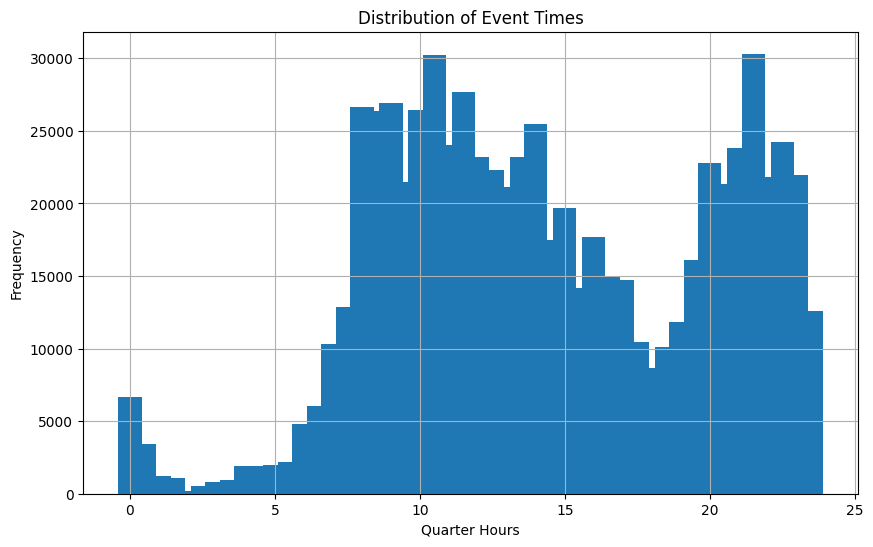

In [65]:
import matplotlib.pyplot as plt

# Count the frequency of each quarter-hour
half_hour_counts = dfs_paradata['half_hour'].value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(10,6))
plt.bar(half_hour_counts.index, half_hour_counts.values)
plt.xlabel('Quarter Hours')
plt.ylabel('Frequency')
plt.title('Distribution of Event Times')
plt.grid(True)
plt.show()
